In [ ]:
from math import asin, log, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import RYGate
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
# AUXILIARY LIBRARIES
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Literal, Tuple, Union

In [ ]:
train = pd.read_csv('../path/train.csv')  # importing dataset


QUBITS = 7        # number of qubits used in the circuit (|0>= not characterized, |1>= characterized)
# positions of the qubits
QPOS_ISCHILD = 0  # position of the qubit representing if the passenger is a child
QPOS_SEX     = 1  # position of the qubit representing if the passenger is a female
QPOS_NORM    = 2  # position of the qubit representing if the passenger is favored by the norm
QPOS_FIRST   = 3  # position of the qubit representing if the passenger is in the first class
QPOS_SECOND  = 4  # position of the qubit representing if the passenger is in the second class
QPOS_THIRD   = 5  # position of the qubit representing if the passenger is in the third class
QPOS_SURV    = 6  # position of the qubit representing survival

In [130]:
max_child_age = 8  # the maximum age of a passenger we consider as a child
train['IsChild'] = train['Age'].map(lambda age: 0 if age > max_child_age else 1)  # Is the passenger a child?

population_child = train[train.Age.le(max_child_age)]
p_child = len(population_child) / len(train)       # probability of being a child
 
population_female = train[train.Sex.eq("female")]
p_female = len(population_female) / len(train)     # probability of being female

pop_first = train[train.Pclass.eq(1)]
p_first = round(len(pop_first) / len(train), 2)    # probability of being in first class

pop_second = train[train.Pclass.eq(2)]
p_second = round(len(pop_second) / len(train), 2)  # probability of being in second class

pop_third = train[train.Pclass.eq(3)]
p_third = round(len(pop_third) / len(train), 2)    # probability of being in third class

surv_first = round(len(pop_first[pop_first.Survived.eq(1)]) / len(pop_first), 2)      # probability of surviving in first class
surv_second = round(len(pop_second[pop_second.Survived.eq(1)]) / len(pop_second), 2)  # probability of surviving in second class
surv_third = round(len(pop_third[pop_third.Survived.eq(1)]) / len(pop_third), 2)      # probability of surviving in third class

print("Probability of being a child: {:.2f}".format(p_child))
print("Probability of being female: {:.2f}".format(p_female))
print("First class: {} of the passengers, survived: {}".format(p_first, surv_first))
print("Second class: {} of the passengers, survived: {}".format(p_second, surv_second))
print("Third class: {} of the passengers, survived: {}".format(p_third, surv_third))

Probability of being a child: 0.06
Probability of being female: 0.35
First class: 0.24 of the passengers, survived: 0.63
Second class: 0.21 of the passengers, survived: 0.47
Third class: 0.55 of the passengers, survived: 0.24


In [131]:
#___________________________________________________________#
####################### PRE-PROCESS #########################


def pre_process(passenger:pd.Series) -> Tuple[bool, bool, int]:
    """Extracts selected features from a Titanic passenger's record for use in quantum model.

    Args:
        passenger (pd.Series): A row from the Titanic dataset representing a single passenger.

    Returns:
        Tuple[bool, bool, int]: A tuple containing:
            - IsChild (bool): True if the passenger is a child, False otherwise.
            - IsFemale (bool): True if the passenger is female, False otherwise.
            - Pclass (int): The passenger class (1, 2, or 3).
    """
    return (passenger['IsChild'] == 1, 
            passenger['Sex'] == 'female',
            passenger['Pclass'])


#___________________________________________________________#
######################## QBN TITANIC ########################


def as_pqc(cnt_quantum:int, circuit_with_qc:Callable[[QuantumCircuit, QuantumRegister, ClassicalRegister], None], cnt_classical:int=1, shots:int=1, measure:bool=False, draw:bool=False) -> Dict[str, Union[float, int]]:
    """Assembles a parameterized quantum circuit based on 'circuit_with_qc' function.

    Args:
        cnt_quantum (int): The number of quantum bits (qubits) in the circuit.
        circuit_with_qc (function): A function that takes a QuantumCircuit and applies the desired quantum operations.
        cnt_classical (int, optional): The number of classical bits in the circuit. Defaults to 1.
        shots (int, optional): The number of shots (repetitions) for the quantum circuit execution. Defaults to 1.
        measure (bool, optional): Whether to include measurement operations in the circuit. Defaults to False.

    Returns:
        dict: The results of the quantum circuit execution.
    """
    # Prepare the circuit with qubits and a classical bit to hold the measurement
    qr = QuantumRegister(cnt_quantum)
    cr = ClassicalRegister(cnt_classical)

    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)
    circuit_with_qc(qc, qr, cr)

    if draw: display(qc.draw('mpl'))
    qc = transpile(qc, basis_gates=['u3', 'cx'], optimization_level=3)
    if measure: job = Aer.get_backend('qasm_simulator').run(qc, shots=shots)
    else:       job = Aer.get_backend('statevector_simulator').run(qc)
    results = job.result().get_counts()

    return results


def apply_ischild_sex(qc:QuantumCircuit) -> None:
    """Applies the isChild and Sex probabilities to the quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to apply the operations.
    
    Returns: None
    """
    qc.ry(prob_to_angle(p_child), QPOS_ISCHILD)  # set the marginal probability of isChild
    qc.ry(prob_to_angle(p_female), QPOS_SEX)     # set the marginal probability of Sex
    qc.barrier()


def apply_norm(qc:QuantumCircuit, norm_params:dict) -> None:
    """Applies the Norm probabilities to the quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to apply the operations.
        norm_params (dict): The normalization parameters. Example:
            {
                'p_norm_am': 0.25,
                'p_norm_af': 0.35,
                'p_norm_cm': 0.45,
                'p_norm_cf': 0.55
            }
    Returns: None
    """

    # set the conditional probability of Norm given adult/male (|00> -> q0 in the right and q1 in the left)
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(norm_params['p_norm_am']), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)
    # set the conditional probability of Norm given adult/female (|10> -> q0 in the right and q1 in the left)
    qc.x(QPOS_ISCHILD)
    ccry(qc, prob_to_angle(norm_params['p_norm_af']), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)
    # set the conditional probability of Norm given child/male (|01> -> q0 in the right and q1 in the left)
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(norm_params['p_norm_cm']), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_SEX)
    # set the conditional probability of Norm given child/female (|11> -> q0 in the right and q1 in the left)
    ccry(qc, prob_to_angle(norm_params['p_norm_cf']), QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)


def apply_class(qc:QuantumCircuit) -> None:
    """Applies the Class probabilities to the quantum circuit.

    Args:
        qc (QuantumCircuit): The quantum circuit to apply the operations.
    """
    # set the marginal probability of Pclass=1st
    qc.ry(prob_to_angle(p_first), QPOS_FIRST)

    qc.x(QPOS_FIRST)
    # set the marginal probability of Pclass=2nd
    qc.cry(prob_to_angle(p_second / (1 - p_first)), QPOS_FIRST, QPOS_SECOND)

    # set the marginal probability of Pclass=3rd
    qc.x(QPOS_SECOND)
    ccry(qc, prob_to_angle(p_third / (1 - p_first - p_second)), QPOS_FIRST, QPOS_SECOND, QPOS_THIRD)
    qc.x(QPOS_SECOND)
    qc.x(QPOS_FIRST)


def apply_survival(qc:QuantumCircuit, surv_params:dict) -> None:
    """Applies the Survival probabilities to the quantum circuit.
    
    Args:
        qc (QuantumCircuit): The quantum circuit to apply the operations.
        surv_params (dict): The survival parameters. Example: 
            {
                'p_surv_f1': 0.3,
                'p_surv_f2': 0.4,
                'p_surv_f3': 0.5,
                'p_surv_u1': 0.6,
                'p_surv_u2': 0.7,
                'p_surv_u3': 0.8
            }
    Returns: None
    """
    # set the conditional probability of Survival given unfavored by norm
    qc.x(QPOS_NORM)
    ccry(qc, prob_to_angle(surv_params['p_surv_u1']), QPOS_NORM, QPOS_FIRST, QPOS_SURV)
    ccry(qc, prob_to_angle(surv_params['p_surv_u2']), QPOS_NORM, QPOS_SECOND, QPOS_SURV)
    ccry(qc, prob_to_angle(surv_params['p_surv_u3']), QPOS_NORM, QPOS_THIRD, QPOS_SURV)
    qc.x(QPOS_NORM)
    
    # set the conditional probability of Survival given favored by norm
    ccry(qc, prob_to_angle(surv_params['p_surv_f1']), QPOS_NORM, QPOS_FIRST, QPOS_SURV)
    ccry(qc, prob_to_angle(surv_params['p_surv_f2']), QPOS_NORM, QPOS_SECOND, QPOS_SURV)
    ccry(qc, prob_to_angle(surv_params['p_surv_f3']), QPOS_NORM, QPOS_THIRD, QPOS_SURV)
    

def calculate_norm_params(passengers:pd.DataFrame) -> dict[str,float]:
    """Calculates the parameters for the norm to QBN.

    Args:
        passengers (DataFrame): The passenger data.

    Returns:
        dict: The norm parameters.
    """
    # Different populations in the data
    pop_children = passengers[passengers.IsChild.eq(1)]
    pop_adults = passengers[passengers.IsChild.eq(0)]

    # Combinations of being child/adult and sex
    pop_am = pop_adults[pop_adults.Sex.eq('male')]
    pop_af = pop_adults[pop_adults.Sex.eq('female')]
    pop_cm = pop_children[pop_children.Sex.eq('male')]
    pop_cf = pop_children[pop_children.Sex.eq('female')]

    norm_params = {
        'p_norm_am': pop_am.Norm.sum() / len(pop_am),
        'p_norm_af': pop_af.Norm.sum() / len(pop_af),
        'p_norm_cm': pop_cm.Norm.sum() / len(pop_cm),
        'p_norm_cf': pop_cf.Norm.sum() / len(pop_cf),
    }

    return norm_params


def calculate_surv_params(passengers:pd.DataFrame) -> dict[str,float]:
    """Calculates the parameters for the survival to QBN.

    Args:
        passengers (DataFrame): The passenger data.

    Returns:
        dict: The survival parameters.
    """
    # All survivors
    survivors = passengers[passengers.Survived.eq(1)]

    # Weight function for each passenger
    def weight_passenger(norm: bool, pclass: int) -> Callable:
        """The weight calculation of a passenger based on the probability that norm favors the passenger (passenger[0]) and class (passenger[1]).

        Args:
            norm (bool): Whether passenger was favored by the norm.
            pclass (int): The passenger class.

        Returns:
            Callable: Function that returns the probability.
        """
        return lambda passenger: (passenger[0] if norm else 1 - passenger[0]) * (1 if passenger[1] == pclass else 0)

    # Calculates the survival probability
    def calc_prob(norm: bool, pclass: int) -> float:
        """Calculates the survival probability for a passenger.

        Args:
            norm (bool): Whether passenger was favored by the norm.
            pclass (int): The passenger class.

        Returns:
            float: The survival probability based on the norm and class.
        """
        num = sum(map(weight_passenger(norm, pclass), list(zip(survivors['Norm'], survivors['Pclass']))))    # number of survivors in a group (numerator)
        den = sum(map(weight_passenger(norm, pclass), list(zip(passengers['Norm'], passengers['Pclass']))))  # total number of passengers in a group (denominator)
        return num / den if den != 0 else 0

    surv_params = {
        'p_surv_f1': calc_prob(True, 1),
        'p_surv_f2': calc_prob(True, 2),
        'p_surv_f3': calc_prob(True, 3),
        'p_surv_u1': calc_prob(False, 1),
        'p_surv_u2': calc_prob(False, 2),
        'p_surv_u3': calc_prob(False, 3)
    }

    return surv_params



#___________________________________________________________#
######################### TRAIN #############################


def filter_states(states:Iterable[Tuple[str, float]], position:int, value:Union[int, str]) -> list[Tuple[str, float]]:
    """ Filters a list of quantum states, keeping only those whose binary string representation has the specified value at a given qubit position.

    Args:
        states (Iterable[Tuple[str, float]]): A list of tuples where each tuple contains a binary string (e.g., '0110') representing the state and a float value (e.g., probability or amplitude).
        position (int): The index of the qubit with the characteristic to be filtred.
        value (Union[int, str]): The expected value (0 or 1) at the specified position; can be passed as an integer or string.

    Returns:
        list[Tuple[str, float]]: A filtered list of states where the specified qubit has the given value.
    """
    return list(filter(lambda item: item[0][QUBITS-1-position] == str(value), states))


def to_params(results: dict[str, float]) -> dict[str, float]:
    """Computes the conditional probabilities of being favored by the "norm" qubit given different combinations of input features: isChild, sex, and survival.

    Args:
        results (Dict[str, float]): Dictionary where keys are binary strings representing quantum states (e.g., '01101') and values are their associated probabilities.

    Returns:
        Dict[str, float]: A dictionary mapping labels for each parameter combination to the computed probability of being favored by the norm. 
        Keys follow the pattern:
            - 'p_norm_amd': adult male   death
            - 'p_norm_ams': adult male   survival
            - 'p_norm_afd': adult female death
            - 'p_norm_afs': adult female survival
            - 'p_norm_cmd': child male   death
            - 'p_norm_cms': child male   survival
            - 'p_norm_cfd': child female death
            - 'p_norm_cfs': child female survival
    """
    states = results.items()

    def calc_norm(ischild_val:str, sex_val:str, surv_val:str) -> float:
        """Calculates the probability of being favored by the norm for a given combination of parameters

        Args:
            ischild_val (str): string '0' (adult) or '1' (child).
            sex_val (str): string '0' (male) or '1' (female).
            surv_val (str): string '0' (death) or '1' (survival).

        Returns:
            float: The probability of being favored by the norm for the given combination of ischild, sex, and survival values.
        """
        pop = filter_states(
            filter_states(
                filter_states(states, QPOS_SEX, sex_val),
                QPOS_ISCHILD, ischild_val),
            QPOS_SURV, surv_val)
        p_norm = sum(map(lambda item: item[1], filter_states(pop, QPOS_NORM, '1')))
        p_total = sum(map(lambda item: item[1], pop))
        return p_norm / p_total if p_total != 0 else 0

    return {
        'p_norm_amd': calc_norm('0', '0', '0'),
        'p_norm_ams': calc_norm('0', '0', '1'),
        'p_norm_afd': calc_norm('0', '1', '0'),
        'p_norm_afs': calc_norm('0', '1', '1'),
        'p_norm_cmd': calc_norm('1', '0', '0'),
        'p_norm_cms': calc_norm('1', '0', '1'),
        'p_norm_cfd': calc_norm('1', '1', '0'),
        'p_norm_cfs': calc_norm('1', '1', '1'),
    }

#-----------------------------------------------------------#

def prepare_data(passengers: pd.DataFrame, params: dict) -> pd.DataFrame:
    """Prepares the passenger data for the QBN model.

    Args:
        passengers (pd.DataFrame): The passenger data containing 'Age', 'Sex', 'Pclass' and 'Survived' columns.
        params (dict): The guess of parameters for the QBN model. Example:
        params = {
            'p_norm_cms': 0.45,
            'p_norm_cmd': 0.46,
            'p_norm_cfs': 0.47,
            'p_norm_cfd': 0.48,
            'p_norm_ams': 0.49,
            'p_norm_amd': 0.51,
            'p_norm_afs': 0.52,
            'p_norm_afd': 0.53,
        }

    Returns:
        pd.DataFrame: The prepared passenger data.
    """
    
    # The probability of favored by norm given Age, Sex, and Survival
    passengers['Norm'] = list(map(  # Creates a new float column or changes the existing column 'Norm' in the DataFrame based on the data 'isChild', 'Sex', and 'Survived' and the parameters guessess
        lambda item: params['p_norm_{}{}{}'.format(
            'a' if item[0] == 0 else 'c',
            item[1][0],
            'd' if item[2] == 0 else 's')],
        zip(passengers['IsChild'], passengers['Sex'], passengers['Survived'])
    ))
    return passengers


def train_qbn_titanic(passengers: pd.DataFrame, params: dict, iterations: int, show: bool=False) -> Dict[str, float]:
    """Train the Quantum Bayesian Network for the Titanic dataset.
    Args:
        passengers (pd.DataFrame): The passenger data.
        params (dict): The initial parameters for the QBN.
        iterations (int): The number of training iterations.
        show (bool, optional): Configures whether to show in the terminal the likelihood. Default: False.
    Returns:
        dict: The trained parameters for the QBN.
    """

    def qbn_titanic(norm_params:dict[str,float], surv_params:dict[str,float], measure:bool=False, shots:int=1) -> Dict[str, float]:
        """Applies the Quantum Bayesian Network (QBN) circuit for Titanic survival prediction using the norm and survival parameters.

        Args:
            norm_params (dict): The normalization parameters from function `calculate_norm_params`.
            surv_params (dict): The survival parameters from function `calculate_surv_params`.
            measure (bool, optional): Whether to measure the circuit. Defaults to False.
            shots (int, optional): Number of simulations to measure. Defaults to 1.

        Returns:
            dict: The results of the QBN.
        """
        def circuit(qc:QuantumCircuit, qr:QuantumRegister, cr:ClassicalRegister) -> None:
            """Circuit for the Quantum Bayesian Network (QBN) for Titanic survival prediction.

            Args:
                qc (QuantumCircuit): The quantum circuit to apply the operations.
                qr (QuantumRegister): The quantum register.
                cr (ClassicalRegister): The classical register.

            Returns: None
            """
            apply_ischild_sex(qc)
            apply_norm(qc, norm_params)
            apply_class(qc)
            apply_survival(qc, surv_params)
        return as_pqc(QUBITS, circuit, measure=measure, shots=shots)

    log_like_lst = list()
    for i in range(iterations):  # Training limited by number of iterations or by log_likelihood variation.
        passengers = prepare_data(passengers, params)                                                # Update the passenger 'Norm' data based on the current parameters
        results = qbn_titanic(calculate_norm_params(passengers), calculate_surv_params(passengers))  # Update the results based on the current passenger data
        params = to_params(results)                                                                  # Refine the parameters using measurement statistics from the quantum circuit
        
        log_like = log_likelihood_titanic(passengers, results)  # Calcules the data log_likelihood
        log_like_lst.append(log_like)
        if log_like_lst and show: print(f'The log-likelihood after {i} iteration(s) is {log_like}')
        
    # Displays the learning curve graph
    if show: graph(list(range(1,iterations+1)), log_like_lst, 'Log-Likelihood During QBN Training', 'Iteration', 'Log-Likelihood')

    return params

#-----------------------------------------------------------#

def apply_known(qc: QuantumCircuit, is_child: bool, is_female: bool, pclass: int) -> None:
    """Encodes known classical information (age group, sex, and passenger class) into the quantum circuit by applying X gates to the corresponding qubits to turn it into a state |1>.

    Args:
        qc (QuantumCircuit): The QuantumCircuit object to which the X gates will be applied.
        is_child (bool): True if the passenger is a child; applies X gate to the child qubit.
        is_female (bool): True if the passenger is female; applies X gate to the sex qubit.
        pclass (int): Passenger class (1, 2, or 3); applies X gate to the corresponding class qubit.

    Returns: None
    """
    if   is_child   : qc.x(QPOS_ISCHILD)
    if   is_female  : qc.x(QPOS_SEX)
    if   pclass == 1: qc.x(QPOS_FIRST)
    elif pclass == 2: qc.x(QPOS_SECOND)
    else            : qc.x(QPOS_THIRD)
    qc.barrier()


def get_trained_qbn(passengers: pd.DataFrame, params: dict, draw: bool=False):
    """Returns a trained quantum Bayesian network model function for Titanic survival prediction.

    The returned function generates and runs a quantum circuit based on a single passenger's data 
    (is_child, is_female, pclass) using trained norm and survival parameters.

    Args:
        passengers (pd.DataFrame): The dataset containing passenger records.
        params (dict): Initial parameter set for training the QBN.
        draw (bool, optional): Whether to display the circuit diagram when executed. Defaults to False.

    Returns:
        Callable[[tuple], dict]: A function that takes a passenger tuple and returns the simulation results.
    """
    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic(passenger: tuple) -> dict:
        """Builds and runs the QBN circuit for a single passenger.

        Args:
            passenger (tuple): A tuple of (is_child: bool, is_female: bool, pclass: int).

        Returns:
            dict: Measurement results from the quantum circuit execution.
        """
        is_child, is_female, pclass = passenger

        def circuit(qc: QuantumCircuit, qr: QuantumRegister, cr: ClassicalRegister) -> None:
            """Defines the quantum circuit for the QBN model using the trained parameters.

            Args:
                qc (QuantumCircuit): The quantum circuit object.
                qr (QuantumRegister): The quantum register used in the circuit.
                cr (ClassicalRegister): The classical register used for measurement.

            Returns: None
            """
            apply_known(qc, is_child, is_female, pclass)
            apply_norm(qc, norm_params)
            apply_survival(qc, surv_params)
            qc.measure(qr[QPOS_SURV], cr[0])

        return as_pqc(QUBITS, circuit, measure=True, shots=100, draw=draw)

    return qbn_titanic



#___________________________________________________________#
####################### POS-PROCESS #########################


def post_process(counts: Dict[str, int]) -> Literal[0, 1]:
    """Determines the final prediction based on measurement counts from the quantum circuit. 
    
    Compares the number of times the qubit was measured in state '1' (survived) versus state '0' (died) from the quantum circuit simulation result, and returns the more probable outcome.

    Args:
        counts (Dict[str, int]): Dictionary with keys '0' and/or '1' representing measurement outcomes 
            and their respective counts (result) from the quantum circuit.

    Returns:
        Literal[0, 1]: 1 if survival is more probable, 0 otherwise.
    """
    p_surv = counts['1'] if '1' in counts.keys() else 0
    p_died = counts['0'] if '0' in counts.keys() else 0
    return 1 if p_surv > p_died else 0



#___________________________________________________________#
#################### TESTING CLASSIFIER #####################


def run(f_classify: Callable[[pd.Series], Any], data: pd.DataFrame) -> List[Any]:
    """ Applies a classification function to each row of the given DataFrame.

    Args:
        f_classify (Callable[[pd.Series], Any]): A function that takes a row (passenger record) and returns a classification result (e.g., 0 or 1).
        data (pd.DataFrame): The dataset where each row represents an individual sample.

    Returns:
        List[Any]: A list containing the classification results for each row in the dataset.
    """
    return [f_classify(data.iloc[i]) for i in tqdm(range(len(data)), desc="Classifying")]


def specificity(matrix: Union[np.ndarray, list]) -> float:
    """ Computes the specificity (true negative rate) from a binary confusion matrix.
        Specificity = TN / (TN + FP), where:
            - TN = True Negatives = matrix[0, 0]
            - FP = False Positives = matrix[0, 1]

    Args:
        matrix (Union[np.ndarray, list]): A 2x2 confusion matrix, where rows represent actual classes and columns represent predicted classes.

    Returns:
        float: The specificity score. Returns 0 if the denominator is 0.
    """
    return matrix[0,0]/(matrix[0,0]+matrix[0,1]) if (matrix[0,0]+matrix[0,1] > 0) else 0


def npv(matrix: Union[np.ndarray, list]) -> float:
    """ Computes the Negative Predictive Value (NPV) from a binary confusion matrix.
        NPV = TN / (TN + FN), where:
            - TN = True Negatives = matrix[0, 0]
            - FN = False Negatives = matrix[1, 0]

    Args:
        matrix (Union[np.ndarray, list]): A 2x2 confusion matrix, where rows represent actual classes and columns represent predicted classes.

    Returns:
        float: The negative predictive value. Returns 0 if the denominator is 0.
    """
    return matrix[0, 0]/(matrix[0, 0]+matrix[1, 0]) if (matrix[0, 0]+matrix[1, 0] > 0) else 0


def classifier_report(name: str, run: Callable[[Callable[[pd.Series], int], pd.DataFrame], list], classify: Callable[[pd.Series], int], input: pd.DataFrame, labels: pd.Series) -> None:
    """ Prints a classification report for a given classifier, including precision, recall, specificity, negative predictive value (NPV), and an aggregated 'information level'.

    Args:
        name (str): Name of the classifier (used in print statements).
        run (Callable): A function that applies the classifier to each row of the input data.
        classify (Callable): The classification function to apply to each row (e.g., passenger).
        input (pd.DataFrame): The feature data used for prediction.
        labels (pd.Series): The ground truth labels (0 or 1) for evaluation.

    Returns: None
    """
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)

    cr_accuracy = accuracy_score(labels, cr_predictions)                  # Accuracy = (TP + TN) / Total: overall proportion of correct predictions
    cr_precision = precision_score(labels, cr_predictions)                # Precision = TP / (TP + FP): proportion of predicted positives that are truly positive
    cr_recall = recall_score(labels, cr_predictions)                      # Recall = TP / (TP + FN): proportion of actual positives that were correctly identified
    cr_specificity = specificity(cr_cm)                                   # Specificity = TN / (TN + FP): how well negatives are correctly identified
    cr_npv = npv(cr_cm)                                                   # NPV = TN / (TN + FN): proportion of predicted negatives that are truly negative
    cr_f1 = f1_score(labels, cr_predictions)                              # Harmonic mean of precision and recall
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)  # Average of precision, recall, specificity, and NPV

    print(f'The accuracy score is {cr_accuracy:.2f}')
    print(f'The precision score of the {name} classifier is {cr_precision:.2f}')      
    print(f'The recall score of the {name} classifier is {cr_recall:.2f}')
    print(f'The specificity score of the {name} classifier is {cr_specificity:.2f}')
    print(f'The npv score of the {name} classifier is {cr_npv:.2f}')
    print(f'The F1 score of the {name} classifier is {cr_f1:.2f}')                    
    print(f'The information level is: {cr_level:.2f}'.format())



#___________________________________________________________#
################### AUXILIARY FUNCTIONS #####################


def prob_to_angle(prob: float) -> float:
    """ Converts a probability into a rotation angle for a Ry gate. 

    Args:
        prob (float): The probability value, between 0 and 1.

    Returns:
        float: The corresponding angle in radians to use in a Ry rotation.
    """
    return 2*asin(sqrt(prob))  # Given a probability p ∈ [0, 1], returns an angle θ such that: sin²(θ/2) = p  =>  θ = 2*arcsin(√p)


def ccry(qc: QuantumCircuit, theta: float, control1: int, control2: int, controlled: int) -> None:       
    """ Applies a controlled-controlled-RY (CCRY) gate to the quantum circuit. 
    
    Manual decomposition (for illustrative purposes):
        qc.cry(theta/2, control2, controlled)
        qc.cx(control1, control2)
        qc.cry(-theta/2, control2, controlled)
        qc.cx(control1, control2)
        qc.cry(theta/2, control1, controlled)

    Args:
        qc (QuantumCircuit): The quantum circuit to modify.
        theta (float): The rotation angle for the Ry gate (in radians).
        control1 (int): Index of the first control qubit.
        control2 (int): Index of the second control qubit.
        controlled (int): Index of the target qubit to which Ry will be applied.

    Returns: None
    """          
    qc.append(RYGate(theta).control(2), [control1, control2, controlled])  # Creates a CCRy(θ) gate with two controls and applies it to the circuit


def log_likelihood_titanic(data: pd.DataFrame, results: Dict[str, float]) -> float:
    """ Computes the log-likelihood of the Titanic dataset given the results from the quantum model. The likelihood is calculated by matching each passenger's attributes (norm, is_child, sex, survival) to a precomputed set of conditional probabilities, then summing the logarithm of the total probability (favorable + unfavorable by norm).

    Args:
        data (pd.DataFrame): The passenger dataset containing the columns: 'Norm', 'IsChild', 'Sex', and 'Survived'.
        results (Dict[str, float]): Dictionary where keys are quantum state strings (e.g., '01101') and values are their associated probabilities or amplitudes squared.

    Returns:
        float: The total log-likelihood of the data given the quantum model.
    """
    states = results.items()

    def calc_prob(norm_val: str, ischild_val: str, sex_val: str, surv_val: str) -> float:
        """ Computes the total probability of all quantum states that match a specific combination of passenger attributes: norm status, child status, sex, and survival. This is done by filtering the quantum result states step-by-step according to the specified values, and summing the probabilities of the matching states.

        Args:
            norm_val (str): '0' if the passenger was not favored by the norm, '1' otherwise.
            ischild_val (str): '0' for adult, '1' for child.
            sex_val (str): '0' for male, '1' for female.
            surv_val (str): '0' for died, '1' for survived.

        Returns:
            float: The total probability of the filtered quantum states matching the given criteria.
        """
        return sum_states(
            filter_states(
                filter_states(
                    filter_states(
                        filter_states(states, QPOS_SEX, sex_val),
                        QPOS_ISCHILD, ischild_val),
                    QPOS_SURV, surv_val),
                QPOS_NORM, norm_val))
    
    # Precompute probabilities for all 16 combinations
    probs = {
        'p_fcms': calc_prob('1', '1', '0', '1'),
        'p_fcmd': calc_prob('1', '1', '0', '0'),
        'p_fcfs': calc_prob('1', '1', '1', '1'),
        'p_fcfd': calc_prob('1', '1', '1', '0'),
        'p_fams': calc_prob('1', '0', '0', '1'),
        'p_famd': calc_prob('1', '0', '0', '0'),
        'p_fafs': calc_prob('1', '0', '1', '1'),
        'p_fafd': calc_prob('1', '0', '1', '0'),
        'p_ucms': calc_prob('0', '1', '0', '1'),
        'p_ucmd': calc_prob('0', '1', '0', '0'),
        'p_ucfs': calc_prob('0', '1', '1', '1'),
        'p_ucfd': calc_prob('0', '1', '1', '0'),
        'p_uams': calc_prob('0', '0', '0', '1'),
        'p_uamd': calc_prob('0', '0', '0', '0'),
        'p_uafs': calc_prob('0', '0', '1', '1'),
        'p_uafd': calc_prob('0', '0', '1', '0'),
    }

    # Data integrity check
    for item in list(zip(data['Norm'], data['IsChild'], data['Sex'], data['Survived'])):
        if len(item) != 4: print("Error: item length is not 4", item)

    # Compute the total log-likelihood
    return round(sum(map(
        lambda item: log(
            probs['p_u{}{}{}'.format(           # ------ FAVORABLE BY NORM ------
                'a' if item[1] == 0 else 'c',   # first letter is adult(a)/child(c)
                item[2][0],                     # second letter is the first letter of passenger sex (m/f)
                'd' if item[3] == 0 else 's'    # third letter is death(d)/survival(s)
            )] + probs['p_f{}{}{}'.format(      # ------ UNFAVORABLE BY NORM ------
                'a' if item[1] == 0 else 'c',   # first letter is adult(a)/child(c)
                item[2][0],                     # second letter is the first letter of passenger sex
                'd' if item[3] == 0 else 's'    # third letter is death(d)/survival(s)
            )]                                  # the probability of the passenger being favored by norm. Ex: log(probs['p_uams']+probs['p_fams'])
        ),
        list(zip(data['Norm'], data['IsChild'], data['Sex'], data['Survived']))
    )), 3)


def sum_states(states: Iterable[Tuple[str, float]]) -> float:
    """ Sums the probabilities or amplitudes of a set of quantum states.

    Args:
        states (Iterable[Tuple[str, float]]): An iterable of tuples where each tuple contains a state string and a float value (e.g., probability or amplitude squared).

    Returns:
        float: The total sum of the second elements (values) of the input tuples.
    """
    return sum(map(lambda item: item[1], states))  # Creates a list with only the probabilities of all states and sums them


def graph(x: Union[List[float], List[int]], y: Union[List[float], List[int]], title: str, x_title: str, y_title: str) -> None:
    """ Plots a customized scatter graph with red circular markers and bold axis titles.

    Args:
        x (Union[List[float], List[int]]): Values for the x-axis.
        y (Union[List[float], List[int]]): Corresponding values for the y-axis.
        title (str): Title of the graph.
        x_title (str): Label for the x-axis.
        y_title (str): Label for the y-axis.

    Returns: None (The function displays the plot directly using matplotlib)
    """
    font_size = 18
    plt.figure()
    plt.plot(x, y, marker='o', linestyle='', markerfacecolor='red', markeredgecolor='red')
    plt.title(title, fontsize=font_size+2, fontweight='bold')
    plt.xlabel(x_title, fontsize=font_size, fontweight='bold')
    plt.ylabel(y_title, fontsize=font_size, fontweight='bold')
    plt.grid(True)
    plt.xticks(fontsize=font_size-2)
    plt.yticks(fontsize=font_size-2)
    plt.tight_layout()
    plt.show()



#___________________________________________________________#
######################## SAMPLING ###########################

# Measures the CPT (Conditional Probability Table) probabilities using Forward Sampling or Rejection Sampling
def get_trained_qbn_samples(passengers: pd.DataFrame, params: Dict[str, float], measure_qubits: List[int], shots: int=1000) -> Dict[str, int]:
    """ Executes a trained Quantum Bayesian Network (QBN) and measures selected qubits. This generalized function allows flexible sampling from the model by specifying which qubits to measure (e.g., Norm, Class, Survival, etc.) via their position constants.

    Args:
        passengers (pd.DataFrame): Passenger dataset used to compute population distributions.
        params (Dict[str, float]): Pre-trained QBN parameters (e.g., from 'train_qbn_titanic()').
        measure_qubits (List[int]): A list containing the qubit indices to be measured. Each item must correspond to the integer value of a qubit position constant (e.g., [QPOS_NORM, QPOS_SECOND, QPOS_SURV]).
        shots (int, optional): Number of times to execute the quantum circuit. Defaults to 1000.
    
    Returns:
        Dict[str, int]: A dictionary of measurement results. Keys are bitstrings corresponding to the measured qubits, in the following hierarchy (from left to right):
            - 1° = Survival (0: died, 1: survived)
            - 2° = 3rd class (bit for QPOS_THIRD)
            - 3° = 2nd class (bit for QPOS_SECOND)
            - 4° = 1st class (bit for QPOS_FIRST)
            - 5° = Norm (0: not favored, 1: favored)
            - 6° = Sex (0 for male, 1 for female)
            - 7° = IsChild (0 for adult, 1 for child)
        (e.g., [QPOS_NORM, QPOS_SECOND, QPOS_SURV] measure returns, for example, '100' representing respectivaly QPOS_SURV (1), QPOS_SECOND (0), and QPOS_NORM(0)).
    """
    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def qbn_titanic() -> Dict[str, int]:
        """ Builds and runs the quantum circuit using the trained QBN parameters. This function defines the circuit structure, applies all conditional gates (e.g., Norm, Survival, Class), amplifies some desired state and performs measurements on the selected qubits.

        Returns:
            Dict[str, int]: Measurement results in the form of bitstrings, corresponding to the selected `measure_qubits`, as defined in the outer function.
        """
        def circuit(qc: QuantumCircuit, qr: QuantumRegister, cr: ClassicalRegister) -> None:
            """ Constructs the quantum circuit for sampling-based methods analysis using a trained QBN. Applies fixed quantum logic to generate IsChild, Sex, Class, Norm, and Survival features. Then conditionally applies amplifiers and measurement operations to the qubits specified in 'measure_qubits' and 'amplify_target'.

            Args:
                qc (QuantumCircuit): The quantum circuit to modify.
                qr (QuantumRegister): The quantum register used by the circuit.
                cr (ClassicalRegister): The classical register where measurements are stored.

            Returns: None
            """
            apply_ischild_sex(qc)
            apply_class(qc)
            apply_norm(qc, norm_params)
            apply_survival(qc, surv_params)

            i = 0
            if QPOS_ISCHILD in measure_qubits: qc.measure(QPOS_ISCHILD, cr[i]); i += 1  # measures whether the passenger is a child 
            if QPOS_SEX     in measure_qubits: qc.measure(QPOS_SEX,     cr[i]); i += 1  # measures the passenger sex 
            if QPOS_NORM    in measure_qubits: qc.measure(QPOS_NORM,    cr[i]); i += 1  # measures whether the passenger was favored by the norm
            if QPOS_FIRST   in measure_qubits: qc.measure(QPOS_FIRST,   cr[i]); i += 1  # measures whether the passenger belongs to the first class
            if QPOS_SECOND  in measure_qubits: qc.measure(QPOS_SECOND,  cr[i]); i += 1  # measures whether the passenger belongs to the second class
            if QPOS_THIRD   in measure_qubits: qc.measure(QPOS_THIRD,   cr[i]); i += 1  # measures whether the passenger belongs to the third class
            if QPOS_SURV    in measure_qubits: qc.measure(QPOS_SURV,    cr[i]); i += 1  # measures whether the passenger survived 

        return as_pqc(QUBITS, circuit, cnt_classical=len(measure_qubits), measure=True, shots=shots)
    return qbn_titanic()

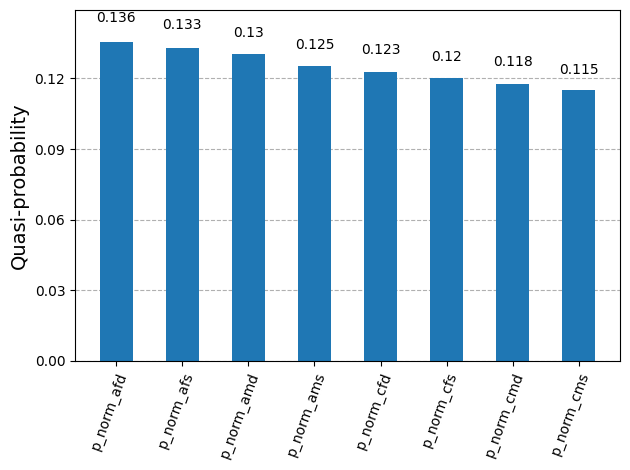

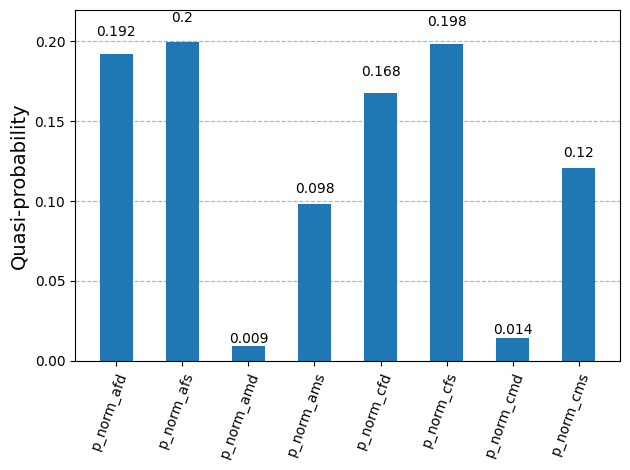

In [132]:
# Step 0: Initialize the parameter values
params = {
    'p_norm_cms': 0.45,
    'p_norm_cmd': 0.46,
    'p_norm_cfs': 0.47,
    'p_norm_cfd': 0.48,
    'p_norm_ams': 0.49,
    'p_norm_amd': 0.51,
    'p_norm_afs': 0.52,
    'p_norm_afd': 0.53,
}


# Step 1: Train the QBN
trained_params = train_qbn_titanic(passengers=train, params=params, iterations=25)  
display(plot_histogram(params))
display(plot_histogram(trained_params))

In [133]:
# Step 2: get the trained simple qbn
trained_qbn = get_trained_qbn(train, trained_params, draw=False)

# Step 3: evaluate the Quantum Bayesian Network
passengers = prepare_data(train, trained_params)

classifier_report(
    "QBN",
    run,
    lambda passenger: post_process(trained_qbn(pre_process(passenger))),
    passengers,
    train['Survived']
)

Classifying:   0%|          | 0/891 [00:00<?, ?it/s]

The accuracy score is 0.79
The precision score of the QBN classifier is 0.79
The recall score of the QBN classifier is 0.62
The specificity score of the QBN classifier is 0.90
The npv score of the QBN classifier is 0.79
The F1 score of the QBN classifier is 0.70
The information level is: 0.78


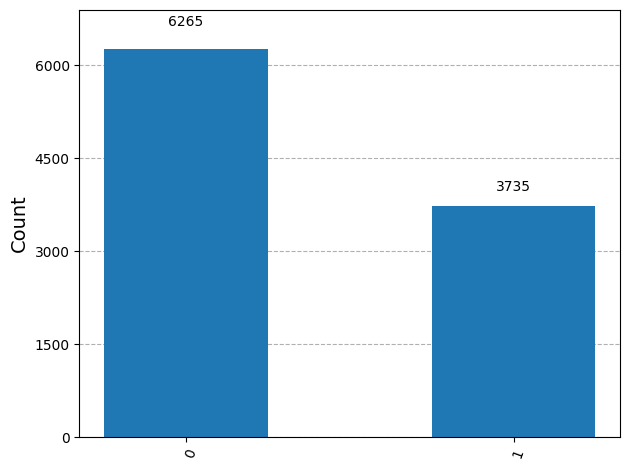

In [134]:
# Forward Sampling
results = get_trained_qbn_samples(train, trained_params,measure_qubits=[QPOS_SURV], shots=10000)  # Survival probability
plot_histogram(results)

In [135]:
# Rejection Sampling
norm_mes = get_trained_qbn_samples(train, trained_params, measure_qubits=[QPOS_NORM, QPOS_ISCHILD, QPOS_SEX], shots=10000)
print("Chance to be favored by norm")
print("Female children: {:.2f}".format(norm_mes['111'] / (norm_mes['111']+norm_mes['011'])))
print("Female adults:   {:.2f}".format(norm_mes['110'] / (norm_mes['110']+norm_mes['010'])))
print("Male children:   {:.2f}".format(norm_mes['101'] / (norm_mes['101']+norm_mes['001'])))
print("Male adults:     {:.2f}".format(norm_mes['100'] / (norm_mes['100']+norm_mes['000'])))

Chance to be favored by norm
Female children: 0.99
Female adults:   0.99
Male children:   0.16
Male adults:     0.13


In [136]:
# Rejection Sampling
surv_mes = get_trained_qbn_samples(train, trained_params,measure_qubits=[QPOS_SURV, QPOS_NORM, QPOS_FIRST, QPOS_SECOND, QPOS_THIRD], shots=10000)
print("Chance to survive")
print("Favored 1st:   {:.2f}".format(surv_mes['10011'] / (surv_mes['10011']+surv_mes['00011'])))
print("Favored 2nd:   {:.2f}".format(surv_mes['10101'] / (surv_mes['10101']+surv_mes['00101'])))
print("Favored 3rd:   {:.2f}".format(surv_mes['11001'] / (surv_mes['11001']+surv_mes['01001'])))
print("Unfavored 1st: {:.2f}".format(surv_mes['10010'] / (surv_mes['10010']+surv_mes['00010'])))
print("Unfavored 2nd: {:.2f}".format(surv_mes['10100'] / (surv_mes['10100']+surv_mes['00100'])))
print("Unfavored 3rd: {:.2f}".format(surv_mes['11000'] / (surv_mes['11000']+surv_mes['01000'])))

Chance to survive
Favored 1st:   0.95
Favored 2nd:   0.87
Favored 3rd:   0.53
Unfavored 1st: 0.24
Unfavored 2nd: 0.07
Unfavored 3rd: 0.07
